# ============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================================================


In [4]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import warnings
import random
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn for metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check TensorFlow version and GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras Version: {keras.__version__}\n")


2025-11-01 06:51:06.933242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761979867.328937      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761979867.446074      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Keras Version: 3.8.0



# ============================================================================
# STEP 2: CONFIGURE DATASET PATHS AND PARAMETERS
# ============================================================================


In [5]:
BASE_PATH = '/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'
WORKING_DIR = '/kaggle/working/alzheimer_split'

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# =====================================================
# CREATE TRAIN / VALIDATION / TEST FOLDERS
# =====================================================
for split in ['train', 'validation', 'test']:
    os.makedirs(os.path.join(WORKING_DIR, split), exist_ok=True)

# =====================================================
# SPLIT DATASET (80% train / 10% val / 10% test)
# =====================================================
def split_data(base_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits = {
            'train': images[:n_train],
            'validation': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_files in splits.items():
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                src = os.path.join(class_path, file)
                dst = os.path.join(split_class_dir, file)
                shutil.copy(src, dst)

print("Splitting dataset...")
split_data(BASE_PATH, WORKING_DIR)
print("Dataset successfully split into train/validation/test folders.\n")


Splitting dataset...
Dataset successfully split into train/validation/test folders.



# ============================================================================
# STEP 3: COUNT AND DISPLAY DATASET STATISTICS
# ============================================================================


In [6]:
def count_images_in_directory(directory):
    class_counts = {}
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return class_counts
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            class_counts[class_name] = len(images)
    return class_counts

# =====================================================
# PRINT DATASET STATISTICS
# =====================================================
print("="*70)
print("DATASET STATISTICS (After Splitting)")
print("="*70)

def print_dataset_stats(name, counts):
    total = 0
    print(f"\n📊 {name.upper()} SET:")
    for class_name, count in sorted(counts.items()):
        print(f"  {class_name}: {count} images")
        total += count
    print(f"  Total {name.capitalize()} Images: {total}")
    return total

train_counts = count_images_in_directory(os.path.join(WORKING_DIR, 'train'))
val_counts = count_images_in_directory(os.path.join(WORKING_DIR, 'validation'))
test_counts = count_images_in_directory(os.path.join(WORKING_DIR, 'test'))

total_train = print_dataset_stats("Training", train_counts)
total_val = print_dataset_stats("Validation", val_counts)
total_test = print_dataset_stats("Test", test_counts)

print(f"\n📈 GRAND TOTAL: {total_train + total_val + total_test} images")
print("="*70 + "\n")

# =====================================================
# CLASS NAMES
# =====================================================
CLASS_NAMES = sorted(train_counts.keys())
NUM_CLASSES = len(CLASS_NAMES)
print(f"Detected Classes ({NUM_CLASSES}): {CLASS_NAMES}\n")

# =====================================================
# FINAL PATHS (for model training)
# =====================================================
TRAIN_DIR = os.path.join(WORKING_DIR, 'train')
VAL_DIR = os.path.join(WORKING_DIR, 'validation')
TEST_DIR = os.path.join(WORKING_DIR, 'test')

print("Paths ready for model:")
print(f"  TRAIN_DIR: {TRAIN_DIR}")
print(f"  VAL_DIR:   {VAL_DIR}")
print(f"  TEST_DIR:  {TEST_DIR}")
print("\nNow your CNN can start training without whining about missing data.")

DATASET STATISTICS (After Splitting)

📊 TRAINING SET:
  MildDemented: 7168 images
  ModerateDemented: 5171 images
  NonDemented: 7680 images
  VeryMildDemented: 7168 images
  Total Training Images: 27187

📊 VALIDATION SET:
  MildDemented: 896 images
  ModerateDemented: 646 images
  NonDemented: 960 images
  VeryMildDemented: 896 images
  Total Validation Images: 3398

📊 TEST SET:
  MildDemented: 896 images
  ModerateDemented: 647 images
  NonDemented: 960 images
  VeryMildDemented: 896 images
  Total Test Images: 3399

📈 GRAND TOTAL: 33984 images

Detected Classes (4): ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

Paths ready for model:
  TRAIN_DIR: /kaggle/working/alzheimer_split/train
  VAL_DIR:   /kaggle/working/alzheimer_split/validation
  TEST_DIR:  /kaggle/working/alzheimer_split/test

Now your CNN can start training without whining about missing data.


# ============================================================================
# STEP 4: VISUALIZE SAMPLE IMAGES FROM EACH CLASS
# ============================================================================


Displaying sample images from training set...



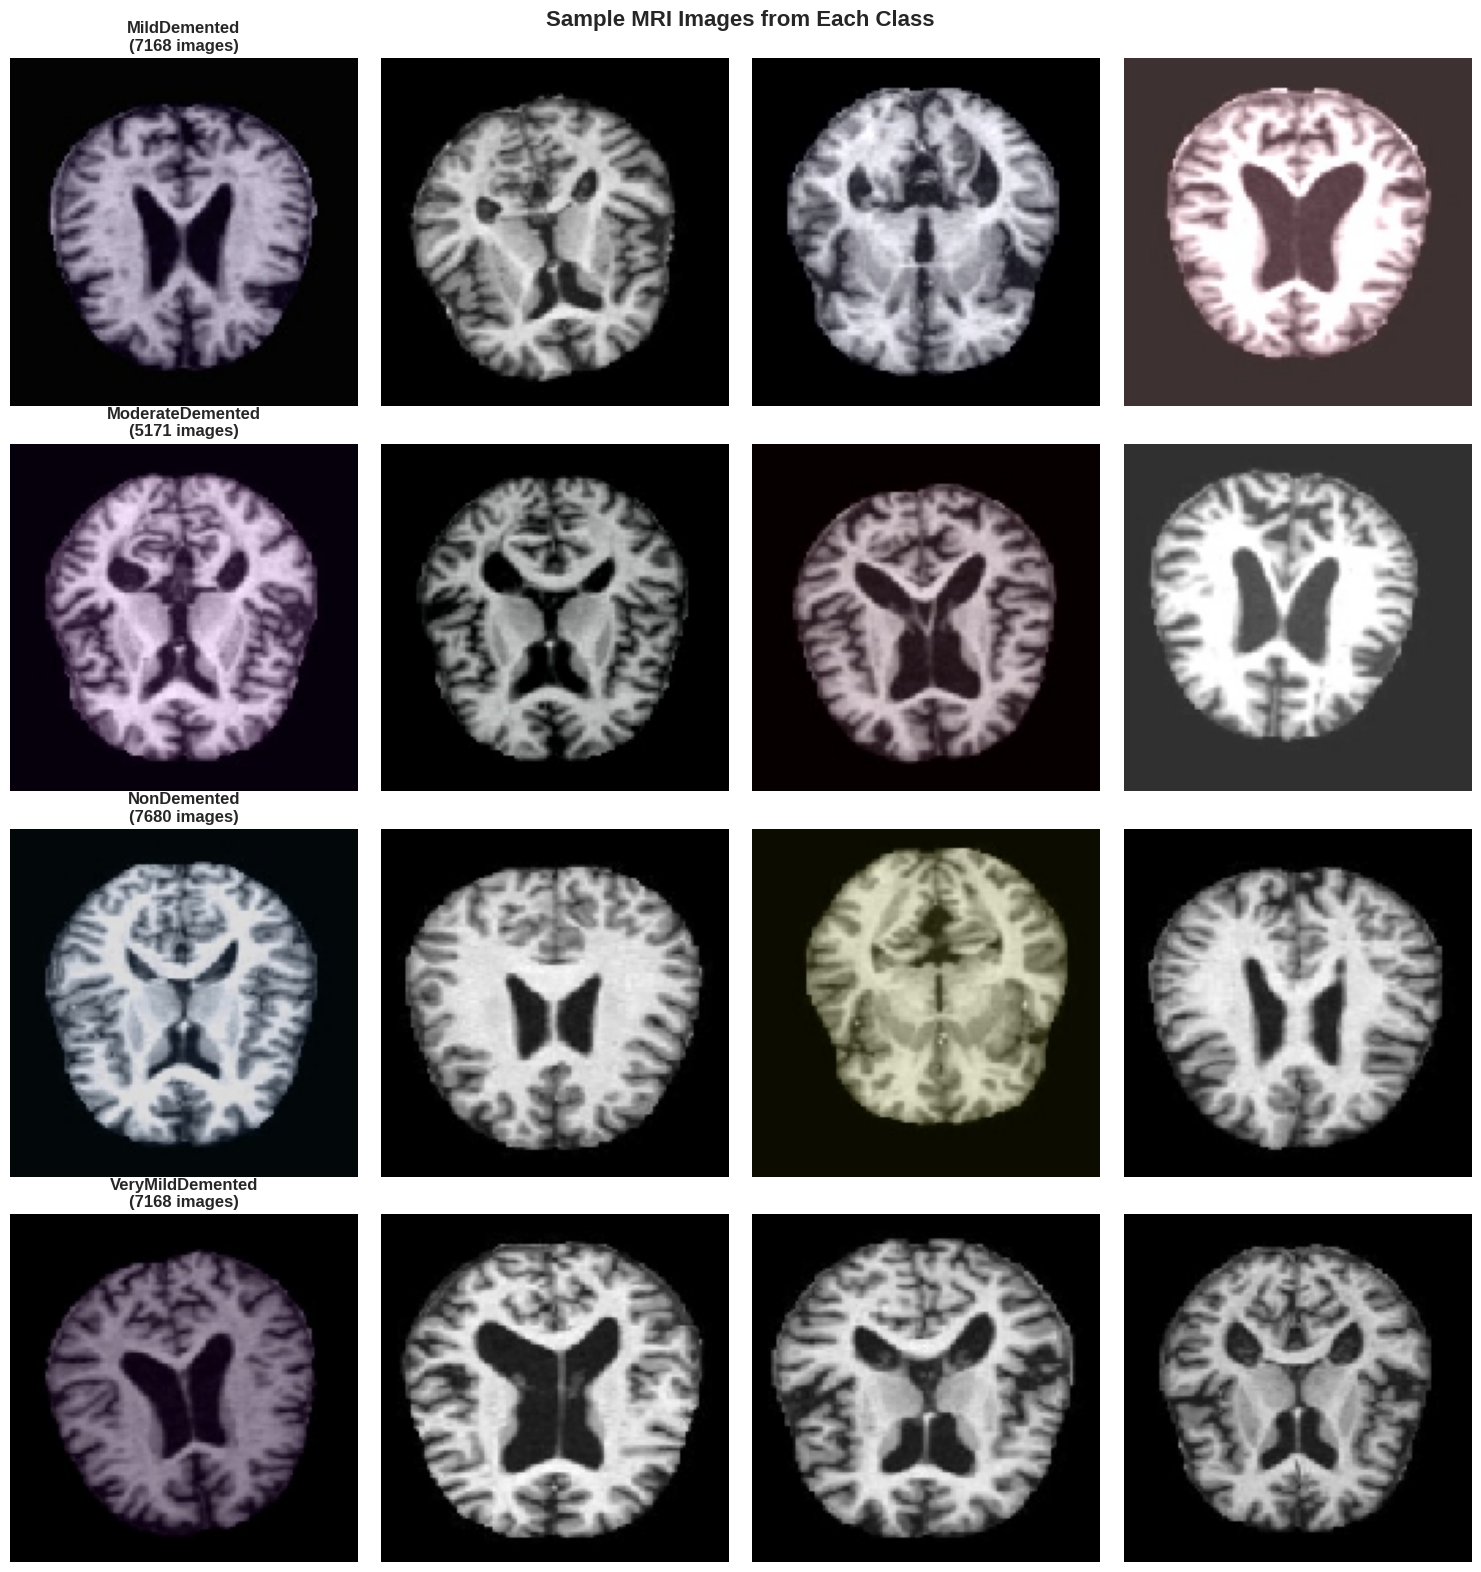


DATA AUGMENTATION AND PREPROCESSING

Found 27187 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 3399 images belonging to 4 classes.
✅ Data generators created successfully!
Training batches: 850
Validation batches: 107
Test batches: 107
Class indices: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}



In [7]:
def display_sample_images(directory, class_names, samples_per_class=3):
    """
    Display sample images from each class in a grid.
    
    Args:
        directory (str): Path to the directory containing class subdirectories
        class_names (list): List of class names
        samples_per_class (int): Number of sample images to display per class
    """
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                             figsize=(15, 4*len(class_names)))
    fig.suptitle('Sample MRI Images from Each Class', fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Select random samples
        selected_images = np.random.choice(image_files, 
                                          min(samples_per_class, len(image_files)), 
                                          replace=False)
        
        for j, img_file in enumerate(selected_images):
            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            
            ax = axes[i, j] if len(class_names) > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(f'{class_name}\n({train_counts.get(class_name, 0)} images)', 
                           fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set...\n")
display_sample_images(TRAIN_DIR, CLASS_NAMES, samples_per_class=4)

# ============================================================================
# STEP 5: CREATE IMAGE DATA GENERATORS WITH AUGMENTATION
# ============================================================================

print("\n" + "="*70)
print("DATA AUGMENTATION AND PREPROCESSING")
print("="*70 + "\n")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values to [0, 1]
    rotation_range=20,                 # Randomly rotate images by 20 degrees
    width_shift_range=0.2,             # Randomly shift images horizontally
    height_shift_range=0.2,            # Randomly shift images vertically
    shear_range=0.2,                   # Apply shear transformation
    zoom_range=0.2,                    # Randomly zoom into images
    horizontal_flip=True,              # Randomly flip images horizontally
    fill_mode='nearest'                # Fill empty pixels after transformation
)

# Validation and test data generators (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',          # Multi-class classification
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print("✅ Data generators created successfully!")
print(f"Training batches: {len(train_generator)}")
print(f"Validation batches: {len(validation_generator)}")
print(f"Test batches: {len(test_generator)}")
print(f"Class indices: {train_generator.class_indices}\n")


# ============================================================================
# STEP 6: BUILD CNN MODEL ARCHITECTURE
# ============================================================================


In [16]:
print("="*70)
print("BUILDING CNN MODEL")
print("="*70 + "\n")

def build_cnn_model(input_shape, num_classes):
    """
    Build a Convolutional Neural Network for image classification.
    
    Args:
        input_shape (tuple): Shape of input images (height, width, channels)
        num_classes (int): Number of output classes
        
    Returns:
        keras.Model: Compiled CNN model
    """
    model = Sequential([

    # Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])
    
    return model

# Build the model
model = build_cnn_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=NUM_CLASSES
)

# Display model architecture
model.summary()


BUILDING CNN MODEL



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,008,804 (19.11 MB)

 Trainable params: 5,007,844 (19.10 MB)

 Non-trainable params: 960 (3.75 KB)

# ============================================================================
# STEP 7: COMPILE THE MODEL
# ============================================================================


In [17]:
print("\n" + "="*70)
print("COMPILING MODEL")
print("="*70 + "\n")

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Loss Function: Categorical Crossentropy")
print(f"Metrics: Accuracy\n")



COMPILING MODEL

✅ Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss Function: Categorical Crossentropy
Metrics: Accuracy



# ============================================================================
# STEP 8: SETUP CALLBACKS
# ============================================================================


In [18]:
print("="*70)
print("CONFIGURING TRAINING CALLBACKS")
print("="*70 + "\n")

# Early Stopping - stops training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint - saves the best model during training
checkpoint = ModelCheckpoint(
    'best_alzheimer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce Learning Rate on Plateau - reduces LR when learning stagnates
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, checkpoint, reduce_lr]

print("✅ Callbacks configured:")
print("  - Early Stopping (patience=10)")
print("  - Model Checkpoint (saves best model)")
print("  - Reduce Learning Rate on Plateau\n")


CONFIGURING TRAINING CALLBACKS

✅ Callbacks configured:
  - Early Stopping (patience=10)
  - Model Checkpoint (saves best model)
  - Reduce Learning Rate on Plateau



# ============================================================================
# STEP 9: TRAIN THE MODEL
# ============================================================================


In [20]:
print("="*70)
print("TRAINING MODEL")
print("="*70 + "\n")

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!\n")


TRAINING MODEL

Epoch 1/30
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8173 - loss: 0.4290
Epoch 1: val_accuracy improved from 0.87846 to 0.89170, saving model to best_alzheimer_model.h5
850/850 ━━━━━━━━━━━━━━━━━━━━ 115s 135ms/step - accuracy: 0.8173 - loss: 0.4290 - val_accuracy: 0.8917 - val_loss: 0.2679 - learning_rate: 5.0000e-04
Epoch 2/30
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8214 - loss: 0.4216
Epoch 2: val_accuracy did not improve from 0.89170
850/850 ━━━━━━━━━━━━━━━━━━━━ 114s 134ms/step - accuracy: 0.8214 - loss: 0.4216 - val_accuracy: 0.8687 - val_loss: 0.3065 - learning_rate: 5.0000e-04
Epoch 3/30
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8298 - loss: 0.4053
Epoch 3: val_accuracy did not improve from 0.89170
850/850 ━━━━━━━━━━━━━━━━━━━━ 115s 135ms/step - accuracy: 0.8298 - loss: 0.4053 - val_accuracy: 0.8908 - val_loss: 0.2586 - learning_rate: 5.0000e-04
Epoch 4/30
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8298 - 

# ============================================================================
# STEP 10: PLOT TRAINING HISTORY
# ============================================================================


Plotting training history...



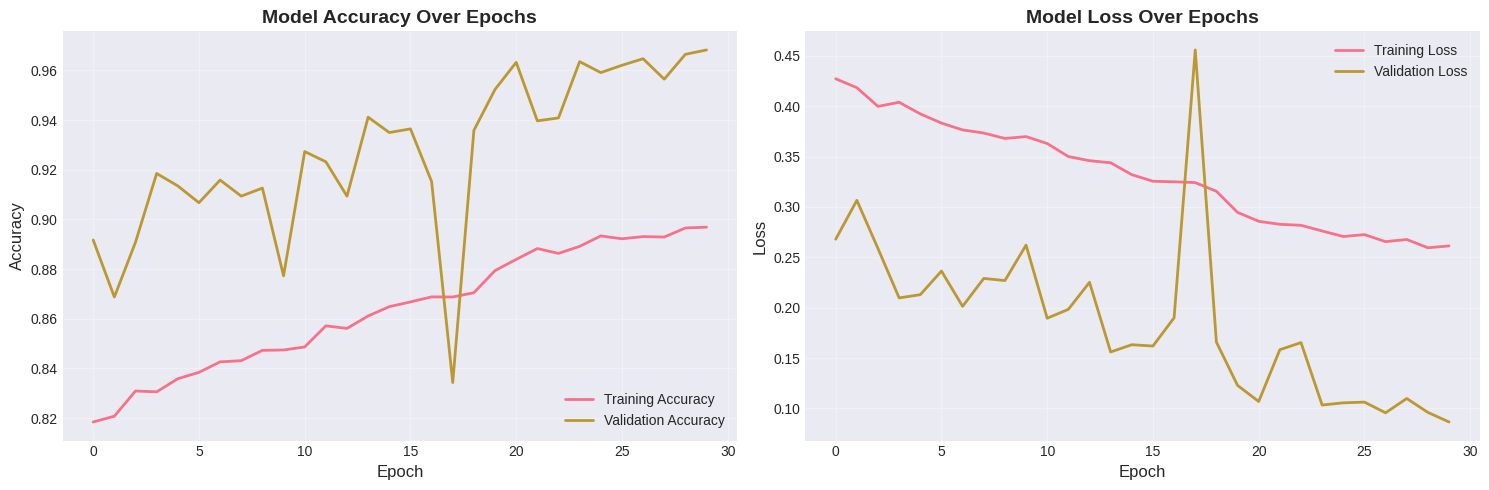


FINAL TRAINING METRICS
Training Accuracy: 0.8969
Validation Accuracy: 0.9682
Training Loss: 0.2613
Validation Loss: 0.0865



In [21]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss curves.
    
    Args:
        history: Keras History object returned from model.fit()
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print("\n" + "="*70)
    print("FINAL TRAINING METRICS")
    print("="*70)
    print(f"Training Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print("="*70 + "\n")

print("Plotting training history...\n")
plot_training_history(history)


# ============================================================================
# STEP 11: EVALUATE MODEL ON TEST SET
# ============================================================================


In [22]:
print("="*70)
print("EVALUATING MODEL ON TEST SET")
print("="*70 + "\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*70}")
print(f"TEST SET RESULTS")
print(f"{'='*70}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*70}\n")


EVALUATING MODEL ON TEST SET

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9819 - loss: 0.0548

TEST SET RESULTS
Test Loss: 0.0911
Test Accuracy: 0.9685 (96.85%)



# ============================================================================
# STEP 12: MAKE PREDICTIONS ON TEST SET
# ============================================================================


In [23]:
print("Making predictions on test set...\n")

# Reset test generator to start from beginning
test_generator.reset()

# Make predictions
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class names in correct order
class_labels = list(test_generator.class_indices.keys())

print(f"\n✅ Predictions completed!")
print(f"Total predictions: {len(y_pred_classes)}\n")


Making predictions on test set...

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step

✅ Predictions completed!
Total predictions: 3399



# ============================================================================
# STEP 13a: CLASSIFICATION REPORT
# ============================================================================


CLASSIFICATION REPORT

                  precision    recall  f1-score   support

    MildDemented     0.9966    0.9844    0.9905       896
ModerateDemented     1.0000    1.0000    1.0000       647
     NonDemented     0.9464    0.9573    0.9518       960
VeryMildDemented     0.9420    0.9420    0.9420       896

        accuracy                         0.9685      3399
       macro avg     0.9713    0.9709    0.9711      3399
    weighted avg     0.9687    0.9685    0.9686      3399

CONFUSION MATRIX



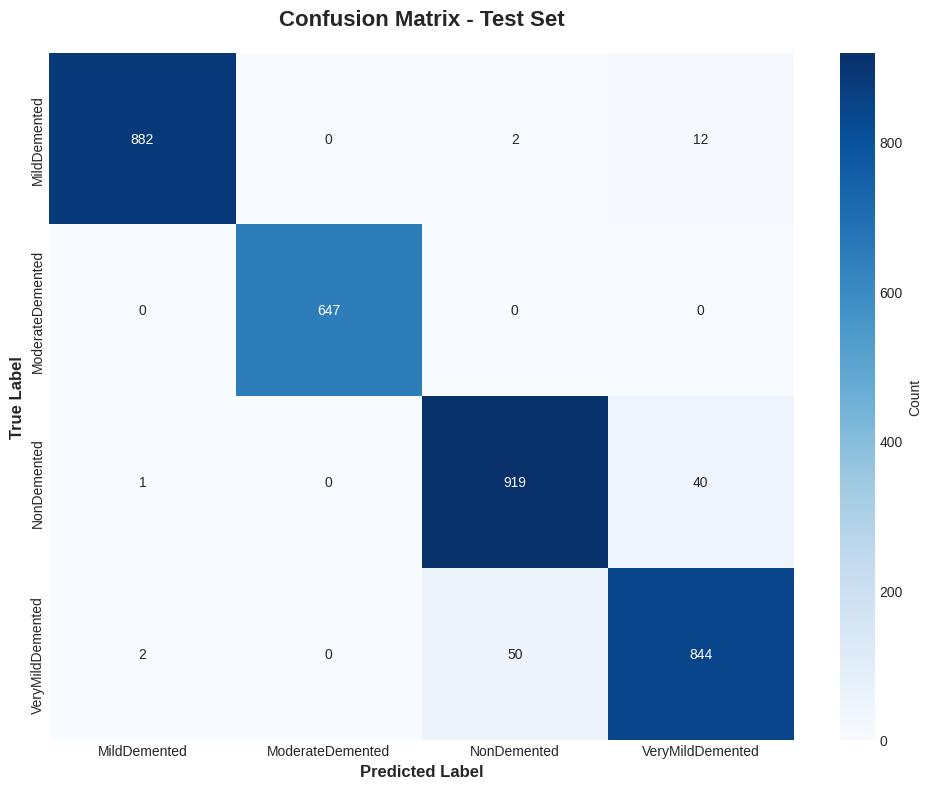


Confusion Matrix (Raw Counts):
[[882   0   2  12]
 [  0 647   0   0]
 [  1   0 919  40]
 [  2   0  50 844]]

Per-Class Accuracy:
  MildDemented: 0.9844 (98.44%)
  ModerateDemented: 1.0000 (100.00%)
  NonDemented: 0.9573 (95.73%)
  VeryMildDemented: 0.9420 (94.20%)

ROC CURVE



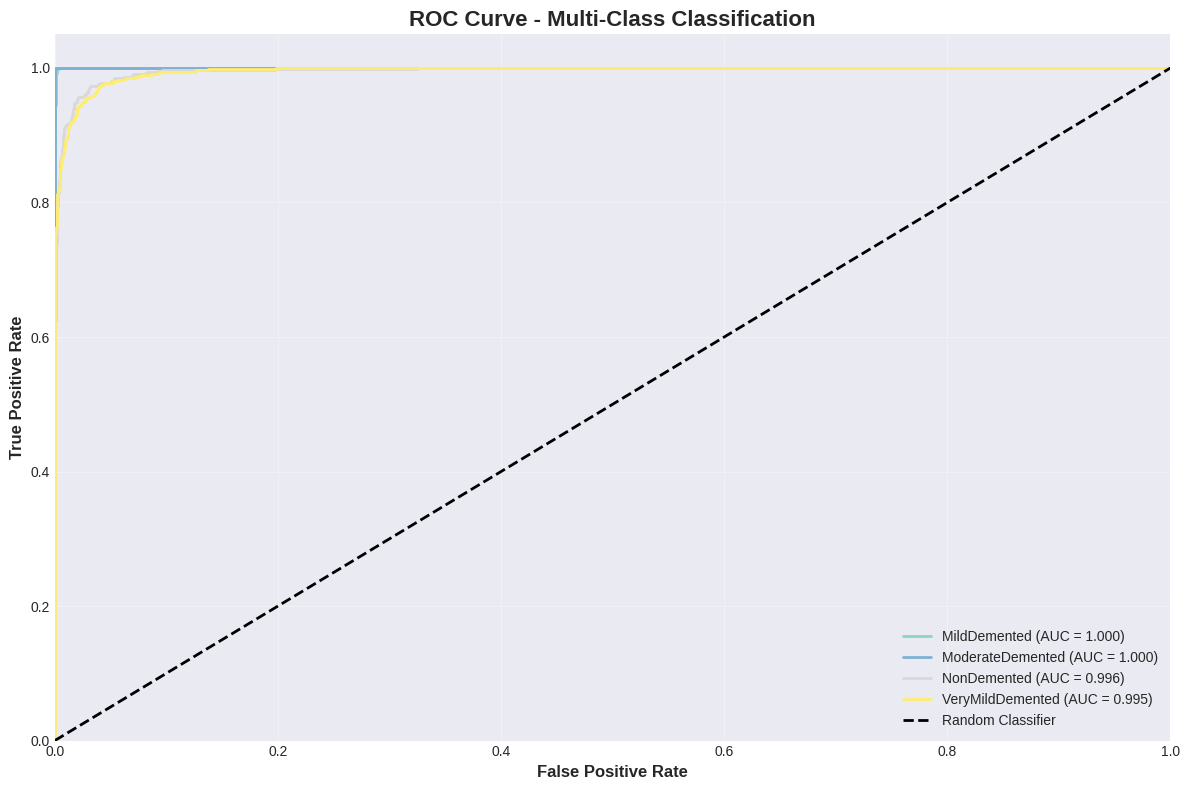

AUC Scores per Class:
  MildDemented: 0.9999
  ModerateDemented: 1.0000
  NonDemented: 0.9957
  VeryMildDemented: 0.9953

Macro-Average AUC: 0.9977

PRECISION-RECALL CURVE



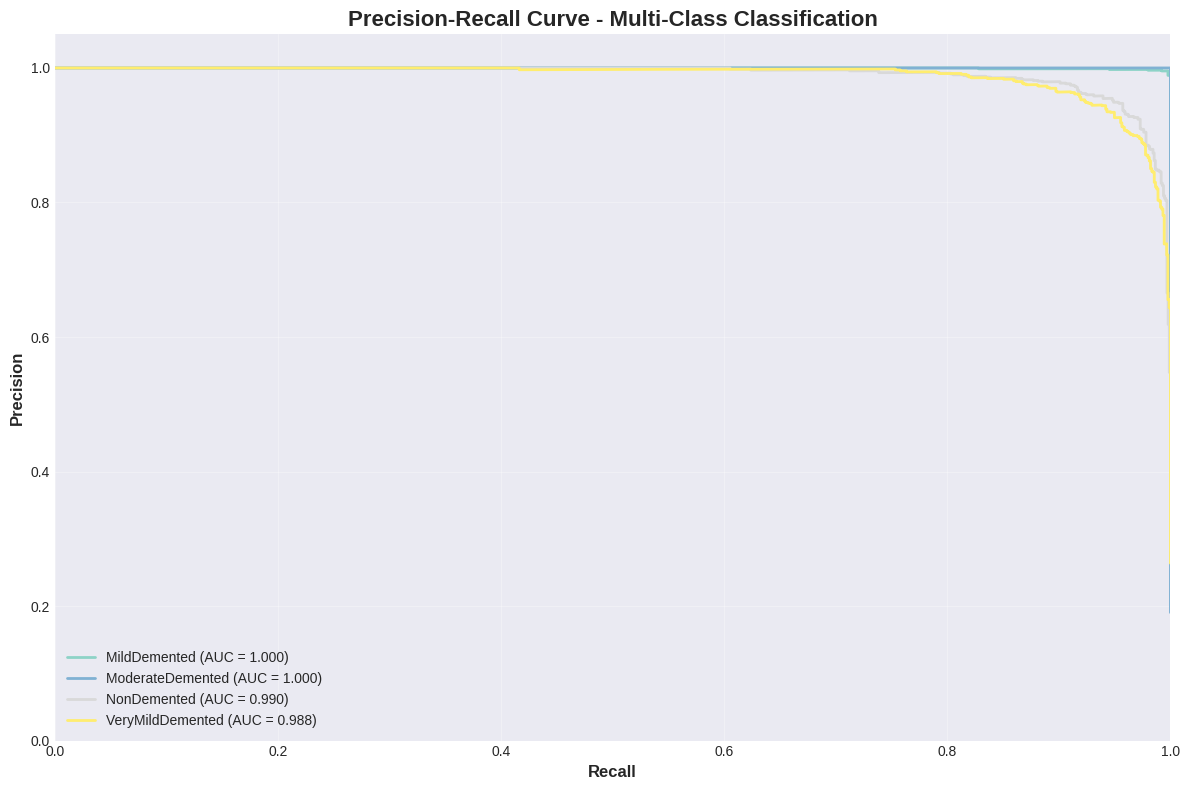

In [24]:
print("="*70)
print("CLASSIFICATION REPORT")
print("="*70 + "\n")

report = classification_report(y_true, y_pred_classes, 
                               target_names=class_labels, 
                               digits=4)
print(report)

# ============================================================================
# STEP 13b: CONFUSION MATRIX
# ============================================================================

print("="*70)
print("CONFUSION MATRIX")
print("="*70 + "\n")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print("\nConfusion Matrix (Raw Counts):")
print(cm)
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_labels):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"  {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# ============================================================================
# STEP 13c: ROC CURVE
# ============================================================================

print("\n" + "="*70)
print("ROC CURVE")
print("="*70 + "\n")

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, NUM_CLASSES))

for i, (class_name, color) in enumerate(zip(class_labels, colors)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("AUC Scores per Class:")
for i, class_name in enumerate(class_labels):
    print(f"  {class_name}: {roc_auc[i]:.4f}")

# Calculate macro and micro average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-Average AUC: {macro_auc:.4f}")

# ============================================================================
# STEP 13d: PRECISION-RECALL CURVE
# ============================================================================

print("\n" + "="*70)
print("PRECISION-RECALL CURVE")
print("="*70 + "\n")

plt.figure(figsize=(12, 8))

for i, (class_name, color) in enumerate(zip(class_labels, colors)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], 
                                                   y_pred_probs[:, i])
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, color=color, lw=2,
             label=f'{class_name} (AUC = {pr_auc:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - Multi-Class Classification', 
          fontsize=16, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# ============================================================================
# STEP 14: TEST ON INDIVIDUAL IMAGES FROM EACH CLASS
# ============================================================================


TESTING ON INDIVIDUAL IMAGES

Image: bd76d7f6-fda5-45bb-8a0c-340dd7463f5c.jpg
  True Label: MildDemented
  Predicted: MildDemented
  Confidence: 0.9976 (99.76%)
  All Probabilities:
    MildDemented: 0.9976
    ModerateDemented: 0.0000
    NonDemented: 0.0000
    VeryMildDemented: 0.0024

Image: cdf17205-a416-4f09-8d58-629360a01318.jpg
  True Label: ModerateDemented
  Predicted: ModerateDemented
  Confidence: 1.0000 (100.00%)
  All Probabilities:
    MildDemented: 0.0000
    ModerateDemented: 1.0000
    NonDemented: 0.0000
    VeryMildDemented: 0.0000

Image: 314113a3-7f4f-4764-9ebe-1dfcf49d61cc.jpg
  True Label: NonDemented
  Predicted: NonDemented
  Confidence: 0.9990 (99.90%)
  All Probabilities:
    MildDemented: 0.0000
    ModerateDemented: 0.0000
    NonDemented: 0.9990
    VeryMildDemented: 0.0010

Image: 44c8e8ac-bce7-432d-9ac1-d24b2a392179.jpg
  True Label: VeryMildDemented
  Predicted: VeryMildDemented
  Confidence: 0.9971 (99.71%)
  All Probabilities:
    MildDemented: 0.000

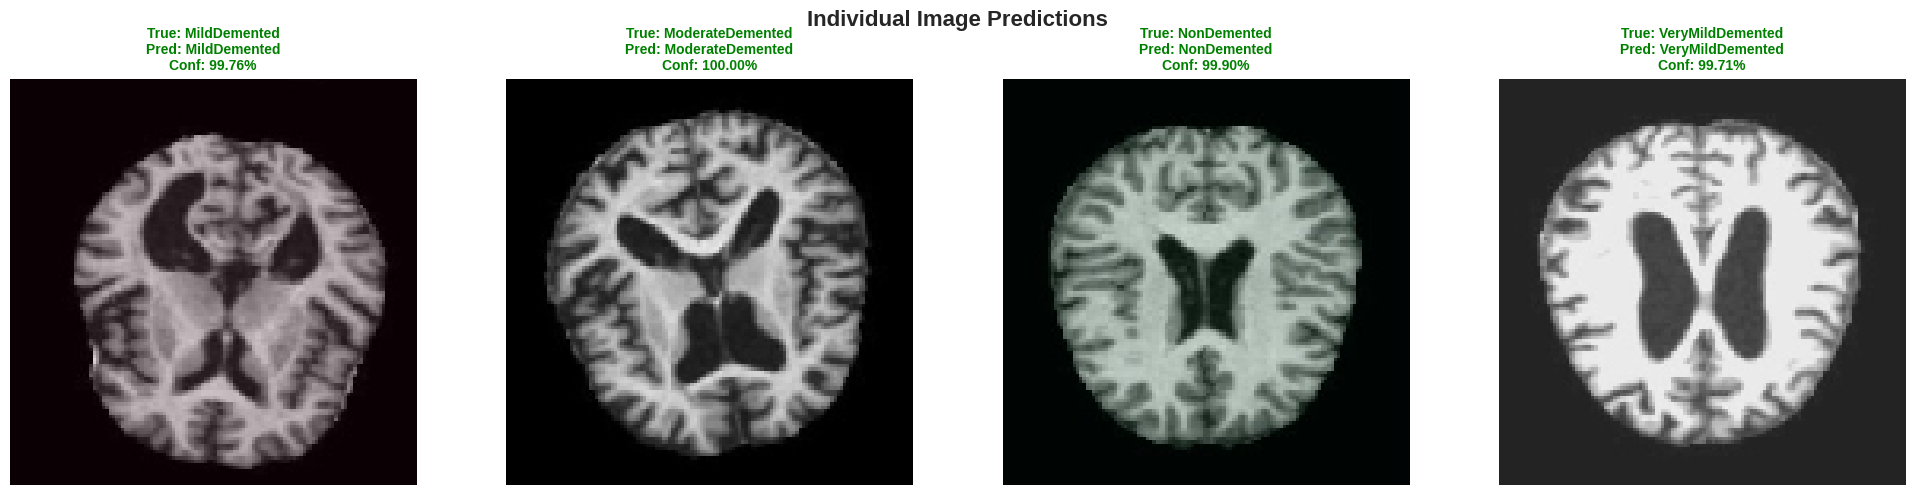

In [25]:
print("="*70)
print("TESTING ON INDIVIDUAL IMAGES")
print("="*70 + "\n")

def predict_single_image(image_path, model, class_labels):
    """
    Load an image, preprocess it, and make a prediction.
    
    Args:
        image_path (str): Path to the image file
        model: Trained Keras model
        class_labels (list): List of class names
        
    Returns:
        tuple: (predicted_class, confidence, probabilities)
    """
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]
    
    return predicted_class, confidence, predictions[0]

# Select one image from each class
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(20, 5))
fig.suptitle('Individual Image Predictions', fontsize=16, fontweight='bold')

for i, class_name in enumerate(class_labels):
    class_path = os.path.join(TEST_DIR, class_name)
    image_files = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select a random image
    selected_image = np.random.choice(image_files)
    image_path = os.path.join(class_path, selected_image)
    
    # Make prediction
    pred_class, confidence, probs = predict_single_image(image_path, model, class_labels)
    
    # Display image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    ax = axes[i] if NUM_CLASSES > 1 else axes
    ax.imshow(img)
    ax.axis('off')
    
    # Set title with prediction results
    title_color = 'green' if pred_class == class_name else 'red'
    ax.set_title(f'True: {class_name}\nPred: {pred_class}\nConf: {confidence:.2%}',
                fontsize=10, fontweight='bold', color=title_color)
    
    # Print detailed results
    print(f"Image: {selected_image}")
    print(f"  True Label: {class_name}")
    print(f"  Predicted: {pred_class}")
    print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  All Probabilities:")
    for j, (label, prob) in enumerate(zip(class_labels, probs)):
        print(f"    {label}: {prob:.4f}")
    print()

plt.tight_layout()
plt.show()


# ============================================================================
# STEP 15: SAVE THE TRAINED MODEL
# ============================================================================


In [26]:
print("="*70)
print("SAVING MODEL")
print("="*70 + "\n")

# Save the final model
model_filename = 'alzheimer_cnn_model.h5'
model.save(model_filename)

print(f"✅ Model saved successfully as '{model_filename}'")
print(f"Model size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")

# Also save model architecture as JSON
model_json = model.to_json()
with open('alzheimer_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print(f"✅ Model architecture saved as 'alzheimer_model_architecture.json'")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print(f"✅ Training history saved as 'training_history.csv'")

print("\n" + "="*70)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)
print("\n📊 Summary:")
print(f"  Total Classes: {NUM_CLASSES}")
print(f"  Training Images: {total_train}")
print(f"  Validation Images: {total_val}")
print(f"  Test Images: {total_test}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Model File: {model_filename}")
print("\n✨ All visualizations and metrics have been generated!")
print("="*70)


SAVING MODEL

✅ Model saved successfully as 'alzheimer_cnn_model.h5'
Model size: 57.42 MB
✅ Model architecture saved as 'alzheimer_model_architecture.json'
✅ Training history saved as 'training_history.csv'

PIPELINE COMPLETED SUCCESSFULLY!

📊 Summary:
  Total Classes: 4
  Training Images: 27187
  Validation Images: 3398
  Test Images: 3399
  Test Accuracy: 0.9685 (96.85%)
  Model File: alzheimer_cnn_model.h5

✨ All visualizations and metrics have been generated!


# ============================================================================
# BONUS: DISPLAY MODEL PERFORMANCE SUMMARY
# ============================================================================


In [27]:
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70 + "\n")

summary_data = {
    'Metric': ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
               'Training Loss', 'Validation Loss', 'Test Loss'],
    'Value': [
        f"{history.history['accuracy'][-1]:.4f}",
        f"{history.history['val_accuracy'][-1]:.4f}",
        f"{test_accuracy:.4f}",
        f"{history.history['loss'][-1]:.4f}",
        f"{history.history['val_loss'][-1]:.4f}",
        f"{test_loss:.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*70)
print("🎉 Notebook execution completed successfully!")
print("="*70)


FINAL PERFORMANCE SUMMARY

             Metric  Value
  Training Accuracy 0.8969
Validation Accuracy 0.9682
      Test Accuracy 0.9685
      Training Loss 0.2613
    Validation Loss 0.0865
          Test Loss 0.0911

🎉 Notebook execution completed successfully!
